In [28]:
# run pip install python-binance if .py file or else try !pip install python-binance
# you ,ight need to pip install riskfolio pip install riskfolio-lib

%pip install python-binance


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import riskfolio as rp
import pandas as pd 
from binance.client import Client
import datetime
import pandas as pd
import datetime
from binance.client import Client
import riskfolio as rp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [ ]:
# Binance API credentials to type in, you can get this info from your binance account
api_key = 'your_api_key'
api_secret = 'your_api_secret'

client = Client(api_key, api_secret)

# List of symbols
info = client.get_all_tickers()
# Extract the values of 'symbol' into a list
#symbols = [ticker['symbol'] for ticker in info]

symbols = ['BTCUSDT', 'ETHBTC', 'LTCBTC'] # we can define a custom list of symbols rather using all possible available coins

# Define custom start and end time
start_time = datetime.datetime.now() - datetime.timedelta(days=1)
end_time = datetime.datetime.now()

# Create an empty dataframe to hold all the data
all_data = pd.DataFrame()

for symbol in symbols:
    klines = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1MINUTE, start_str=str(start_time), end_str=str(end_time))
    
    # Convert the data into a pandas dataframe for easier manipulation
    df = pd.DataFrame(klines, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])
    
    columns_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']
    
    for col in columns_to_convert:
        df[col] = df[col].astype(float)
        
    # Add a new column for the symbol
    df['Symbol'] = symbol
    
    # Append the data to the all_data dataframe
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop=True, inplace=True)

# Pivot the table to get the desired structure to work with riskfolio
pivot_df = all_data.pivot_table(values='Close', index='Open Time', columns='Symbol')
print(pivot_df)

Symbol           BTCUSDT   ETHBTC    LTCBTC
Open Time                                  
1738531320000   97298.04  0.03024  0.001123
1738531380000   97324.96  0.03024  0.001123
1738531440000   97234.01  0.03023  0.001125
1738531500000   97341.65  0.03026  0.001126
1738531560000   97336.00  0.03024  0.001126
...                  ...      ...       ...
1738613820000  101438.93  0.02690  0.001030
1738613880000  101454.56  0.02687  0.001028
1738613940000  101413.56  0.02685  0.001027
1738614000000  101634.39  0.02687  0.001028
1738614060000  101712.71  0.02690  0.001028

[1380 rows x 3 columns]


Symbol          BTCUSDT    ETHBTC    LTCBTC
Open Time                                  
1738531380000  0.000277  0.000000  0.000000
1738531440000 -0.000934 -0.000331  0.001781
1738531500000  0.001107  0.000992  0.000889
1738531560000 -0.000058 -0.000661  0.000000
1738531620000 -0.001838 -0.003307 -0.001776
<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 1738531380000 to 1738614060000
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTCUSDT  1379 non-null   float64
 1   ETHBTC   1379 non-null   float64
 2   LTCBTC   1379 non-null   float64
dtypes: float64(3)
memory usage: 43.1 KB
None
Y shape: (1379, 3)
Y is empty: False
Symbol
BTCUSDT    0
ETHBTC     0
LTCBTC     0
dtype: int64
Symbol       BTCUSDT       ETHBTC       LTCBTC
count   1.379000e+03  1379.000000  1379.000000
mean    3.341281e-05    -0.000078    -0.000058
std     1.572266e-03     0.003753     0.003403
min    -1.155454e-02    -0.085725    -0.061246
25%

/tmp/ipykernel_27293/2398516787.py:40: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='single')


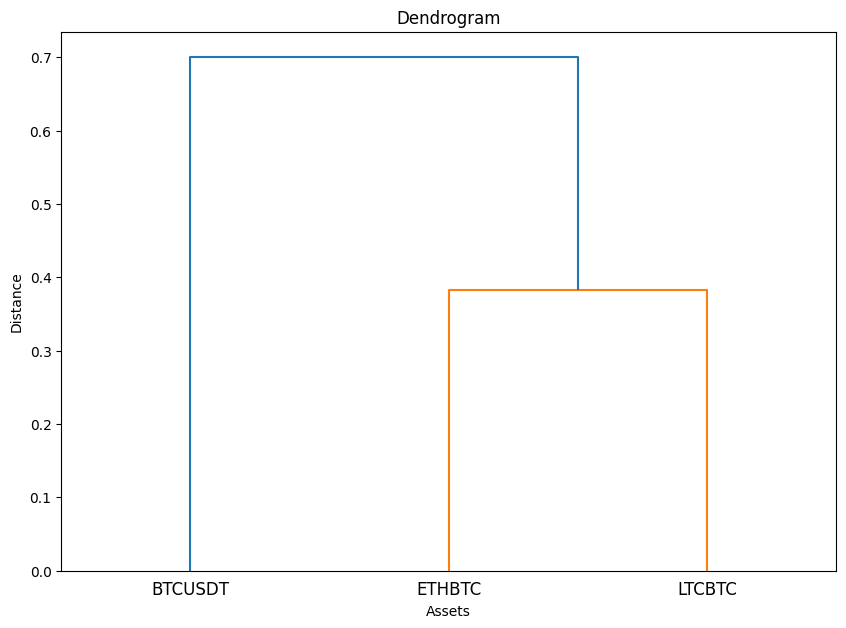

          BTCUSDT  ETHBTC    LTCBTC
weights  0.655878  0.1756  0.168522


In [31]:
prices = pivot_df.copy()

# Calculate returns
Y = prices.pct_change().dropna()

# Print the structure and contents of Y
print(Y.head())  # Print the first few rows to check the structure
print(Y.info())  # Print info to check data types and non-null counts
print("Y shape:", Y.shape)  # Print the shape of Y
print("Y is empty:", Y.empty)  # Check if Y is empty

# Check for NaN values
print(Y.isna().sum())

# Describe the DataFrame to check for unexpected values
print(Y.describe())

# Check the number of unique rows and columns
print("Number of unique rows in Y:", len(Y.drop_duplicates()))
print("Number of unique columns in Y:", Y.nunique())

# Attempt hierarchical clustering with scipy
try:
    if not Y.empty and len(Y.drop_duplicates()) > 1 and (Y.nunique() > 1).all():
        # Compute the correlation matrix
        correlation_matrix = Y.corr()
        print("Correlation matrix:\n", correlation_matrix)

        # Compute the distance matrix
        distance_matrix = 1 - correlation_matrix

        # Perform hierarchical clustering
        linkage_matrix = sch.linkage(distance_matrix, method='single')
        
        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram = sch.dendrogram(linkage_matrix, labels=correlation_matrix.columns)
        plt.title('Dendrogram')
        plt.xlabel('Assets')
        plt.ylabel('Distance')
        plt.show()
    else:
        print("The DataFrame 'Y' is not suitable for plotting a dendrogram (check rows and columns).")
except ValueError as e:
    print("An error occurred while plotting the dendrogram:", e)

# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio
model = 'HRP'  # Could be HRP or HERC
codependence = 'pearson'  # Correlation matrix used to group assets in clusters
rm = 'CVaR'  # Risk measure used, this time will be CVaR
rf = 0  # Risk free rate
linkage = 'single'  # Linkage method used to build clusters
max_k = 10  # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True  # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

print(w.T)

In [35]:
# Risk Measures available:
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'GMD': Gini Mean Difference.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'TG': Tail Gini.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax).
# 'RG': Range of returns.
# 'CVRG': CVaR Range of returns.
# 'TGRG': Tail Gini Range of returns.
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.

rms = ['vol', 'MV', 'MAD', 'GMD', 'MSV', 'FLPM', 'SLPM', 'VaR',
       'CVaR', 'TG', 'EVaR', 'WR', 'RG', 'CVRG', 'TGRG', 'MDD', 
       'ADD', 'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel',
       'ADD_Rel', 'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=i,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
print(w_s)
# Calculate the mean by row
mean_by_row = w_s.mean(axis=1)
# Display the result
print(f"Average weights by risk score optimization: {mean_by_row}")

              vol        MV       MAD       GMD       MSV      FLPM      SLPM  \
BTCUSDT  0.678569  0.816078  0.585554  0.594607  0.718328  0.603960  0.722958   
ETHBTC   0.152850  0.082981  0.234519  0.226581  0.129162  0.221889  0.127183   
LTCBTC   0.168581  0.100941  0.179927  0.178812  0.152510  0.174151  0.149860   

              VaR      CVaR        TG  ...       DaR      CDaR      EDaR  \
BTCUSDT  0.556523  0.655878  0.692254  ...  0.732161  0.732649  0.754693   
ETHBTC   0.265881  0.175600  0.149383  ...  0.146567  0.145696  0.127012   
LTCBTC   0.177596  0.168522  0.158363  ...  0.121272  0.121654  0.118295   

              UCI   MDD_Rel   ADD_Rel   DaR_Rel  CDaR_Rel  EDaR_Rel   UCI_Rel  
BTCUSDT  0.770273  0.753734  0.791276  0.730317  0.729054  0.746419  0.770685  
ETHBTC   0.117027  0.124535  0.103974  0.144412  0.144890  0.129898  0.115082  
LTCBTC   0.112700  0.121731  0.104749  0.125270  0.126056  0.123683  0.114233  

[3 rows x 27 columns]
Average weights by risk sco